In [1]:
%matplotlib inline
from __future__ import print_function
from keras.models import Model, Sequential
from keras.engine.training import slice_X
from keras.layers import Lambda, Flatten, Permute, Reshape, Input
from keras.layers import merge, Merge, Activation, TimeDistributed, Dense, RepeatVector, recurrent
import numpy as np
from six.moves import range
import keras.backend as K
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pylab as pl
import matplotlib.cm as cm
from scipy.special import expit

Using Theano backend.


In [2]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, chars, maxlen):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.chars)))
        for i, c in enumerate(C):
            X[i, self.char_indices[c]] = 1
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)

In [3]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [666]:
# Parameters for the model and dataset
TRAINING_SIZE = 5000
DIGITS = 2
OPS = 2
INVERT = True
# Try replacing GRU, or SimpleRNN
RNN = recurrent.LSTM
HIDDEN_SIZE = 32
BATCH_SIZE = 128
LAYERS = 1
MAXLEN = OPS * DIGITS + OPS - 2

In [667]:
chars = '0123456789+ '
ctable = CharacterTable(chars, MAXLEN)

In [954]:
def generate_data(training_size, num_digits, num_ops):
    questions = []
    expected = []
    seen = set()
    print('Generating data... ')
    while len(questions) < training_size:
#         f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, num_digits + 1))))
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(num_digits)))
        ops = []
        for i in range(num_ops):
            ops.append(f())
                    
        # Skip any addition questions we've already seen
        # Also skip any such that X+Y == Y+X (hence the sorting)
#         ops.sort()
        key = tuple(ops)
        if key in seen:
            continue
        seen.add(key)
        # Pad the data with spaces such that it is always MAXLEN
        ops_str = []
        for op in ops:
            if (op<10):
                ops_str.append(' ' + str(op))
            else:
                ops_str.append(str(op))
        
        q = ''.join([str(op) for op in ops_str])
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(sum(ops))
        # Answers can be of maximum size DIGITS + 1
        if INVERT:
            query = query[::-1]
            ans = ans[::-1]
        ans += ' ' * (num_digits + 1 - len(ans))
        questions.append(query)
        expected.append(ans)
#         print(len(questions))
    print('Total addition questions:', len(questions))
    
    return questions, expected

In [964]:
def create_train_valid(questions, expected, num_digits, num_ops, percentage):
    print('Vectorization...')
    X = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
    y = np.zeros((len(questions), num_digits + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        X[i] = ctable.encode(sentence, maxlen=MAXLEN)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, maxlen=num_digits + 1)

    # Shuffle (X, y) in unison as the later parts of X will almost all be larger digits
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Explicitly set apart 10% for validation data that we never train over
    split_at = len(X) - len(X)*percentage
    (X_train, X_val) = (slice_X(X, 0, split_at), slice_X(X, split_at))
    (y_train, y_val) = (y[:split_at], y[split_at:])

    print(X_train.shape)
    print(y_train.shape)
    
    return X_train, y_train, X_val, y_val

In [670]:
def build_model(hidden_size, num_layers, num_digits, num_ops):
    # Most simple seq2seq model using encoder-decoder framework
    print('Build model...')
    model = Sequential()
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder = RNN(hidden_size, input_shape=(MAXLEN, len(chars)))
    model.add(encoder)
    # For the decoder's input, we repeat the encoded input for each time step
    model.add(RepeatVector(num_digits + 1))
    # The decoder RNN could be multiple layers stacked or a single layer
    for _ in range(num_layers):
        decoder = RNN(hidden_size, return_sequences=True)
        model.add(decoder)

    # For each of step of the output sequence, decide which character should be chosen
    mapper = TimeDistributed(Dense(len(chars)))
    model.add(mapper)
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    inputs = [K.learning_phase()] + model.inputs
    encoder_f = K.function(inputs, [encoder.output])
    decoder_f = K.function(inputs, [decoder.output])
    mapper_f = K.function(inputs, [mapper.output])
    
    return model, encoder_f, decoder_f, mapper_f, encoder, decoder, mapper

In [671]:
import theano.tensor as T

def get_last_Y(X):
    return X[:, -1, :]

def get_Y(X, xmaxlen):
    return X[:, :xmaxlen, :]  # get first xmaxlen elem from time dim

def get_R(X):
    Y, alpha = X[0], X[1]
    ans = K.T.batched_dot(Y, alpha)
    return ans

def get_R_shape(input_shape):
    shape = list(input_shape)
    outshape = (shape[0][0],shape[0][1])
    return tuple(outshape)

def stack_R(X):
    r_1, r_2, r_3 = X[0], X[1], X[2]
    ans = K.concatenate([r_1, r_2, r_3], axis=1)
    return ans

def get_stack_R_shape(input_shape):
    shape = list(input_shape)
    outshape = (shape[0][0],3,shape[0][2])
    return tuple(outshape)

def stack_decoder_input(X):
    Y, r = X[0], X[1]
    ans = K.concatenate([Y, r], axis=2)
    return ans

def stack_decoder_input_shape(input_shape):
    shape = list(input_shape)
    outshape = (shape[0][0], shape[0][1], shape[0][2]+shape[1][2])
    return tuple(outshape)

def build_att_seq2seq_model(hidden_size, num_layers, num_digits, num_ops, chars):    
    main_input = Input(shape=(MAXLEN,len(chars)), name='main_input')
    
    encoder = RNN(hidden_size, 
                  input_shape=(MAXLEN, len(chars)),
                  return_sequences=True)(main_input)
#     encoder = RNN((num_digits+1)*hidden_size, 
#                   input_shape=(MAXLEN, len(chars)),
#                   return_sequences=True)(main_input)

#     Y = Lambda(get_Y, arguments={"xmaxlen": MAXLEN}, name="Y", output_shape=(MAXLEN, hidden_size))(encoder)    

#     last_Y = Lambda(get_last_Y, name="last_Y", output_shape=((num_digits+1)*hidden_size,))(encoder)
#     Y = Reshape((num_digits+1, hidden_size))(last_Y)
    last_Y = Lambda(get_last_Y, name="last_Y", output_shape=(hidden_size,))(encoder)
    Y = RepeatVector(num_digits+1)(last_Y)
    
    WY1 = TimeDistributed(Dense(len(chars)), name="WY1")(main_input)
#     WY2 = TimeDistributed(Dense(len(chars)), name="WY2")(main_input)
#     WY3 = TimeDistributed(Dense(len(chars)), name="WY3")(main_input)

#     WY1 = TimeDistributed(Dense(hidden_size), name="WY1")(Y)
#     WY2 = TimeDistributed(Dense(hidden_size), name="WY2")(Y)
#     WY3 = TimeDistributed(Dense(hidden_size), name="WY3")(Y)

    M1 = Activation('tanh', name="M1")(WY1)
    M2 = Activation('tanh', name="M2")(WY1)
    M3 = Activation('tanh', name="M3")(WY1)

#     M1 = Activation('tanh', name="M1")(WY1)
#     M2 = Activation('tanh', name="M2")(WY2)
#     M3 = Activation('tanh', name="M3")(WY3)

    alpha_1 = TimeDistributed(Dense(1, activation='linear'), name="alpha_1")(M1)
    alpha_2 = TimeDistributed(Dense(1, activation='linear'), name="alpha_2")(M2)
    alpha_3 = TimeDistributed(Dense(1, activation='linear'), name="alpha_3")(M3)
    flat_alpha1 = Flatten(name="flat_alpha1")(alpha_1)
    flat_alpha2 = Flatten(name="flat_alpha2")(alpha_2)
    flat_alpha3 = Flatten(name="flat_alpha3")(alpha_3)
    alpha1 = Dense(MAXLEN, activation='softmax', name="alpha1")(flat_alpha1)
    alpha2 = Dense(MAXLEN, activation='softmax', name="alpha2")(flat_alpha2)
    alpha3 = Dense(MAXLEN, activation='softmax', name="alpha3")(flat_alpha3)

    Y_trans = Permute((2, 1), name="y_trans")(Y)  # of shape (None,300,20)
    Input_trans = Permute((2, 1), name="input_trans")(main_input)

    r_1 = merge([Input_trans, alpha1], output_shape=get_R_shape, name="r_1", mode=get_R)
    r_2 = merge([Input_trans, alpha2], output_shape=get_R_shape, name="r_2", mode=get_R)
    r_3 = merge([Input_trans, alpha3], output_shape=get_R_shape, name="r_3", mode=get_R)

    r1 = Reshape((1,len(chars)))(r_1)
    r2 = Reshape((1,len(chars)))(r_2)
    r3 = Reshape((1,len(chars)))(r_3)
    
    r = merge([r1, r2, r3], mode=stack_R, output_shape=get_stack_R_shape)
    
    decoder_input = merge([Y, r], mode=stack_decoder_input, output_shape=stack_decoder_input_shape)            
    decoded_result = RNN(hidden_size, input_shape=(num_digits+1, hidden_size), return_sequences=True)(decoder_input)
    mapping = TimeDistributed(Dense(len(chars)))(decoded_result)
    out = Activation('softmax')(mapping)
    
    output = out
    model = Model(input=[main_input], output=output)
#     model = Model(input=[main_input], output=r)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    inputs = [K.learning_phase()] + model.inputs
    a1 = model.get_layer('alpha1')
    a2 = model.get_layer('alpha2')
    a3 = model.get_layer('alpha3')
    alpha1_f = K.function(inputs, [a1.output])
    alpha2_f = K.function(inputs, [a2.output])
    alpha3_f = K.function(inputs, [a3.output])

    return model, alpha1_f, alpha2_f, alpha3_f, a1, a2, a3

In [672]:
from keras.layers import Reshape

def build_seq_model(hidden_size, num_layers, num_digits, num_ops):
    # Most simple seq2seq model using encoder-decoder framework
    print('Build model...')
    model = Sequential()
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder = RNN(hidden_size*(num_digits+1), input_shape=(MAXLEN, len(chars)))
    model.add(encoder)
    # For the decoder's input, we repeat the encoded input for each time step
    model.add(Reshape((num_digits+1, hidden_size)))
    # The decoder RNN could be multiple layers stacked or a single layer
    for _ in range(num_layers):
        decoder = RNN(hidden_size, return_sequences=True)
        model.add(decoder)

    # For each of step of the output sequence, decide which character should be chosen
    mapper = TimeDistributed(Dense(len(chars)))
    model.add(mapper)
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    inputs = [K.learning_phase()] + model.inputs
    encoder_f = K.function(inputs, [encoder.output])
    decoder_f = K.function(inputs, [decoder.output])
    mapper_f = K.function(inputs, [mapper.output])
    
    return model, encoder_f, decoder_f, mapper_f, encoder, decoder, mapper

In [673]:
from keras.layers import Input, merge, TimeDistributedDense
from keras.models import Model

def feedback_model(hidden_size, num_layers, num_digits, num_ops):
    ## Alternative model architecture
    encoder_input = Input(shape=(MAXLEN, len(chars)), name = 'encoder_input')
    decoder_input = Input(shape=(num_digits + 1, len(chars)), name = 'decoder_input')

    x = RNN(hidden_size)(encoder_input)
    context_input = RepeatVector(num_digits + 1)(x)
    x = merge([context_input, decoder_input], mode='concat')
    x = RNN(hidden_size, return_sequences=True)(x)

#     loss = TimeDistributed(Dense(len(chars), activation='softmax'))(x)
    loss = TimeDistributedDense(len(chars), activation='softmax')(x)
    
    model_alt = Model(input=[encoder_input, decoder_input], output=[loss])
    model_alt.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model_alt

In [674]:
def learning(model, X_train, y_train, iterations, X_val, y_val):
    y_true = []
    for idx in range(y_val.shape[0]):
        y_true.append(ctable.decode(y_val[idx]))

#     val_acc_array = []
#     # Train the model each generation and show predictions against the validation dataset
#     for iteration in range(1, iterations):
#         print()
#         print('-' * 50)
#         print('Iteration', iteration)
#         training_obj = model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=1,
#                   validation_data=(X_val, y_val))
#         ###
#         # Select 10 samples from the validation set at random so we can visualize errors
#     #     for i in range(10):
#     #         ind = np.random.randint(0, len(X_val))
#     #         rowX, rowy = X_val[np.array([ind])], y_val[np.array([ind])]
#     #         preds = model.predict_classes(rowX, verbose=0)
#     #         q = ctable.decode(rowX[0])
#     #         correct = ctable.decode(rowy[0])
#     #         guess = ctable.decode(preds[0], calc_argmax=False)
#     #         print('Q', q[::-1] if INVERT else q)
#     #         print('T', correct)
#     #         print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)
#     #         print('---')

# #         preds = model.predict_classes(X_val, verbose=0)
# #         y_preds = []
# #         for idx in range(preds.shape[0]):
# #             y_preds.append(ctable.decode(preds[idx], calc_argmax=False))

# #         acc = accuracy_score(y_true, y_preds)
#         acc = training_obj.history['val_acc']
#         val_acc_array.append(acc)
#         print('Current validation accuracy = ' + str(acc))
    
#     return val_acc_array
    training_obj = model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=iterations,
        validation_data=(X_val, y_val))

In [1029]:
DIGITS = 2
OPS = 2
TRAINING_SIZE = 10000
questions, expected = generate_data(TRAINING_SIZE, DIGITS, OPS)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, DIGITS, OPS, 0.9)
# model, encoder_f_, decoder_f_, mapper_f_, encoder, decoder, mapper = build_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
# model, encoder_f_, decoder_f_, mapper_f_, encoder, decoder, mapper = build_att_seq2seq_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS, chars)
# val_acc_2_2 = learning(model, X_train, y_train, 50, X_val, y_val)

# y_train_pre = np.zeros(y_train.shape)
# for idx in range(len(y_train_pre)):
#     y_train_pre[idx][1:] = y_train[idx][:-1]
# y_val_pre = np.zeros(y_val.shape)
# for idx in range(len(y_val_pre)):
#     y_val_pre[idx][1:] = y_val[idx][:-1]
    
# fb_model = feedback_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
# fb_val_acc_2_2 = learning(fb_model, [X_train, y_train_pre], y_train, 50, [X_val, y_val_pre], y_val)

Generating data... 
Total addition questions: 10000
Vectorization...
(1000, 4, 12)
(1000, 3, 12)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [1032]:
model, alpha1_f, alpha2_f, alpha3_f, aplha1, alpha2, alpha3 = build_att_seq2seq_model(32, LAYERS, DIGITS, OPS, chars)
# val_acc_2_2 = learning(model, X_train, y_train, 100, X_val, y_val)
learning(model, X_train, y_train, 300, X_val, y_val)

Train on 1000 samples, validate on 9000 samples
Epoch 1/300
1000/1000 [==============================] - 0s - loss: 2.4689 - acc: 0.1180 - val_loss: 2.4472 - val_acc: 0.1783
Epoch 2/300
1000/1000 [==============================] - 0s - loss: 2.4323 - acc: 0.2073 - val_loss: 2.4073 - val_acc: 0.2300
Epoch 3/300
1000/1000 [==============================] - 1s - loss: 2.3875 - acc: 0.2443 - val_loss: 2.3548 - val_acc: 0.2484
Epoch 4/300
1000/1000 [==============================] - 0s - loss: 2.3264 - acc: 0.2630 - val_loss: 2.2838 - val_acc: 0.2610
Epoch 5/300
1000/1000 [==============================] - 0s - loss: 2.2476 - acc: 0.2810 - val_loss: 2.1994 - val_acc: 0.2725
Epoch 6/300
1000/1000 [==============================] - 0s - loss: 2.1679 - acc: 0.2830 - val_loss: 2.1393 - val_acc: 0.2744
Epoch 7/300
1000/1000 [==============================] - 0s - loss: 2.1245 - acc: 0.2760 - val_loss: 2.1140 - val_acc: 0.2808
Epoch 8/300
1000/1000 [==============================] - 0s - loss: 2.

In [1034]:
basic_model, encoder_f, decoder_f, mapper_f, encoder, decoder, mapper = build_model(32, LAYERS, DIGITS, OPS)
learning(basic_model, X_train, y_train, 500, X_val, y_val)

Build model...
Train on 1000 samples, validate on 9000 samples
Epoch 1/500
1000/1000 [==============================] - 0s - loss: 2.4656 - acc: 0.1750 - val_loss: 2.4488 - val_acc: 0.2186
Epoch 2/500
1000/1000 [==============================] - 0s - loss: 2.4331 - acc: 0.2377 - val_loss: 2.4124 - val_acc: 0.2431
Epoch 3/500
1000/1000 [==============================] - 0s - loss: 2.3902 - acc: 0.2517 - val_loss: 2.3596 - val_acc: 0.2517
Epoch 4/500
1000/1000 [==============================] - 0s - loss: 2.3260 - acc: 0.2587 - val_loss: 2.2806 - val_acc: 0.2523
Epoch 5/500
1000/1000 [==============================] - 0s - loss: 2.2352 - acc: 0.2530 - val_loss: 2.1852 - val_acc: 0.2524
Epoch 6/500
1000/1000 [==============================] - 0s - loss: 2.1523 - acc: 0.2613 - val_loss: 2.1377 - val_acc: 0.2647
Epoch 7/500
1000/1000 [==============================] - 0s - loss: 2.1228 - acc: 0.2760 - val_loss: 2.1133 - val_acc: 0.2754
Epoch 8/500
1000/1000 [==============================] 

In [1035]:
valid_queries = []
for i in range(len(X_val)):
    X_str = ctable.decode(X_val[i], calc_argmax=True)
    valid_queries.append(X_str[::-1])
    ans = ctable.decode(y_val[i], calc_argmax=True)
    
    preds = basic_model.predict(X_val[i].reshape([1,4,12]), verbose=0)
    y_hat = preds[0].argmax(axis=-1)
    y_str = ''.join(ctable.indices_char[x] for x in y_hat)# ctable.indices_char[x]
    print(X_str[::-1] + '=' + ans[::-1] + ', pred=' + y_str[::-1])

5133= 84, pred= 84
63 1= 64, pred= 64
5727= 84, pred= 83
8238=120, pred=120
3663= 99, pred= 99
6811= 79, pred= 79
17 7= 24, pred= 33
6344=107, pred=197
4523= 68, pred= 68
7632=108, pred=108
9812=110, pred=110
4476=120, pred=120
9413=107, pred= 07
46 4= 50, pred= 40
 091= 91, pred= 92
8838=126, pred=126
2260= 82, pred= 82
7288=160, pred=160
8423=107, pred=107
 717= 24, pred= 23
9340=133, pred=133
2022= 42, pred= 43
2729= 56, pred= 56
76 3= 79, pred= 79
 129= 30, pred= 20
7427=101, pred=101
6352=115, pred=115
8599=184, pred=184
2968= 97, pred= 97
2030= 50, pred= 50
4691=137, pred=137
9345=138, pred=138
2564= 89, pred= 89
3995=134, pred=134
7157=128, pred=128
6177=138, pred=138
3016= 46, pred= 46
42 8= 50, pred= 50
5545=100, pred=100
8955=144, pred=144
 629= 35, pred= 36
1486=100, pred=190
3473=107, pred=107
30 5= 35, pred= 25
9722=119, pred=119
8817=105, pred=105
8562=147, pred=147
2012= 32, pred= 42
5672=128, pred=128
27 1= 28, pred= 28
7137=108, pred=108
 976= 85, pred= 85
4040= 80, pr

In [1009]:
def alpha1_f_(X):
    # The [0] is to disable the training phase flag
    return alpha1_f([0] + [X])

def alpha2_f_(X):
    # The [0] is to disable the training phase flag
    return alpha2_f([0] + [X])

def alpha3_f_(X):
    # The [0] is to disable the training phase flag
    return alpha3_f([0] + [X])

In [1012]:
letter_acc1 = 0
letter_total1 = 0
letter_acc2 = 0
letter_total2 = 0
seq_acc1 = 0
seq_total1 = 0
seq_acc2 = 0
seq_total2 = 0
for a in range(10):
    for b in range (10):
        for x in range(10):
            for y in range(10):
                if (a*10+x <= b*10+y):
                    continue
                    
                ops = []
                ops.append(a*10+x)
                ops.append(b*10+y)

                ops_str = []
                for op in ops:
                    if (op<10):
                        ops_str.append(' ' + str(op))
                    else:
                        ops_str.append(str(op))
                
                q = ''.join([op for op in ops_str])
                query = q + ' ' * (MAXLEN - len(q))
                ans = str(sum(ops))
                # Answers can be of maximum size DIGITS + 1
                if INVERT:
                    query = query[::-1]
                    ans = ans[::-1]
                ans += ' ' * (DIGITS + 1 - len(ans))

                X = ctable.encode(query, maxlen=MAXLEN).reshape([1,4,12])

                preds = basic_model.predict(X, verbose=0)
                y_hat = preds[0].argmax(axis=-1)
                y_str = ''.join(ctable.indices_char[x] for x in y_hat)# ctable.indices_char[x]

                preds2 = model.predict(X, verbose=0)
                y_hat2 = preds2[0].argmax(axis=-1)
                y_str2 = ''.join(ctable.indices_char[x] for x in y_hat2)# ctable.indices_char[x]

                wrong1 = False
                wrong2 = False
                for i in range(len(ans)):
                    if ans[i]==y_str[i]:
                        letter_acc1 += 1
                    else:
                        wrong1 = True
                    if ans[i]==y_str2[i]:
                        letter_acc2 += 1
                    else:
                        wrong2 = True

                if wrong1 or wrong2:
                    print('(' + query[::-1] + ', ' + ans[::-1] + '): ' + y_str[::-1] + ', ' + y_str2[::-1])
                
                if not wrong1:
                    seq_acc1 += 1
                if not wrong2:
                    seq_acc2 += 1

            
                letter_total1 += len(ans)
                letter_total2 += len(ans)
                seq_total1 += 1
                seq_total2 += 1
        
print('Character accuracy for basic model: ' + str(float(letter_acc1)/float(letter_total1)))
print('Character accuracy for attentional model: ' + str(float(letter_acc2)/float(letter_total2)))
print('Sequence accuracy for basic model: ' + str(float(seq_acc1)/float(seq_total1)))
print('Sequence accuracy for attentional model: ' + str(float(seq_acc2)/float(seq_total2)))

( 1 0,   1):  11,   1
( 6 3,   9):  19,   9
( 7 0,   7):  17,   7
( 9 0,   9):  19,   9
(10 0,  10):  11,  10
(10 3,  13):  12,  13
(11 4,  15):   5,  15
(12 7,  19):  29,  29
(13 0,  13):  12,  13
(13 6,  19):  29,  29
(16 3,  19):  29,  29
(17 2,  19):  19,  29
(17 9,  26):  25,  26
(18 8,  26):  25,  26
(19 7,  26):  25,  26
(1210,  22):  21,  22
(1310,  23):  22,  23
(1410,  24):  24,  23
(1917,  36):  35,  36
(20 1,  21):  22,  21
(21 0,  21):  22,  21
(27 9,  36):  35,  36
(28 8,  36):  35,  35
(29 7,  36):  35,  36
(2310,  33):  32,  33
(2410,  34):  34,  33
(2719,  46):  45,  46
(2818,  46):  45,  46
(31 0,  31):  32,  31
(37 9,  46):  45,  46
(38 8,  46):  45,  46
(39 7,  46):  45,  46
(3812,  50):  50,  40
(3630,  66):  66,  65
(4011,  51):  51,  41
(54 0,  54):  55,  54
(54 2,  56):  56,  46
(56 4,  60):  60,  50
(59 9,  68):  67,  68
(5410,  64):  65,  64
(5149, 100): 100,  90
(64 0,  64):  65,  64
(6410,  74):  75,  74
(6139, 100): 100, 190
(7012,  82):  81,  82
(7713,  90

In [1005]:
acc2

14750

In [990]:
X_str = '9997'
X_str = X_str[::-1]
print(X_str)
X = ctable.encode(X_str, maxlen=MAXLEN).reshape([1,4,12])
preds = basic_model.predict(X, verbose=0)
y_hat = preds[0].argmax(axis=-1)
y_str = ''.join(ctable.indices_char[x] for x in y_hat)# ctable.indices_char[x]
print(y_str)
preds2 = model.predict(X, verbose=0)
y_hat2 = preds2[0].argmax(axis=-1)
y_str2 = ''.join(ctable.indices_char[x] for x in y_hat2)# ctable.indices_char[x]
print(y_str2)

7999
681
681


In [987]:
a1 = alpha1_f_(X)
a2 = alpha2_f_(X)
a3 = alpha3_f_(X)

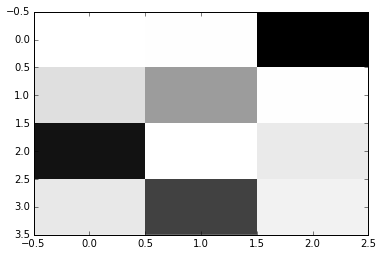

In [988]:
alphas = np.concatenate((a1[0], a2[0], a3[0]))
pl.imshow(np.transpose(alphas), interpolation='none', cmap=cm.binary, aspect='auto')
plt.show()

In [898]:
a1[0]

array([[  7.75741187e-05,   7.31187424e-01,   2.52840329e-04,
          2.68482162e-01]])

In [754]:
a2[0]

array([[  8.88112800e-03,   9.90582447e-01,   3.67220297e-04,
          1.69204911e-04]])

In [345]:
a3[0]

array([[ 0.15537305,  0.26883156,  0.36084677,  0.21494863]])

In [698]:
ctable.decode(X_train[0],calc_argmax=True)

'5766'

In [701]:
ctable.decode(y_train[0], calc_argmax=True)

'141'

In [843]:
train_queries = []
for i in range(len(X_train)):
    X_str = ctable.decode(X_train[i], calc_argmax=True)
    train_queries.append(X_str[::-1])
    y_str = ctable.decode(y_train[i], calc_argmax=True)
    print(X_str[::-1] + '=' + y_str[::-1])

6131= 92
7412= 86
6819= 87
4483=127
8255=137
5972=131
8344=127
5155=106
8014= 94
8690=176
6795=162
68 8= 76
6060=120
2996=125
7085=155
 044= 44
5773=130
1987=106
3420= 54
6261=123
5011= 61
2086=106
55 6= 61
3269=101
 728= 35
6678=144
6545=110
 7 7= 14
5639= 95
4579=124
5198=149
4212= 54
13 4= 17
 524= 29
 330= 33
7626=102
4410= 54
8342=125
3456= 90
5332= 85
1648= 64
58 5= 63
9886=184
90 4= 94
 813= 21
3082=112
1217= 29
4088=128
9137=128
4011= 51
4340= 83
5390=143
 978= 87
1911= 30
62 4= 66
6174=135
9188=179
8248=130
1878= 96
6251=113
6318= 81
5796=153
6772=139
 573= 78
5242= 94
2445= 69
4183=124
9862=160
3924= 63
7016= 86
2468= 92
9442=136
 854= 62
66 4= 70
8357=140
5487=141
8228=110
4160=101
5539= 94
6892=160
6346=109
 184= 85
4796=143
3150= 81
4272=114
7261=133
 175= 76
3196=127
25 7= 32
1182= 93
9376=169
2197=118
64 5= 69
4395=138
7673=149
7390=163
8751=138
4222= 64
3950= 89
51 3= 54
5440= 94
6749=116
6515= 80
1176= 87
7267=139
2275= 97
46 5= 51
6145=106
6074=134
2066= 86
3253= 85
9

In [847]:
count = 0
for query in train_queries:
    if query[1]=='8' and query[3]=='0':
        print(query)
        count += 1

5820
 880
6850
 890
3820
58 0
9880
 850
1870
6880
7870
5850
5860
7810
7860
8820
4840
1820
8840
1880
9840
1850
4850
8860
7850
5890
1890
2850
4870
68 0
 820
1810
9870
9850
1840
3850
3830
5830
88 0
7890


In [845]:
count

51